In [5]:
# STEP 1: Setup and imports
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, FloatSlider, IntSlider, Layout, Button, HBox, VBox, Output

# CONFIGURATION - Change these values for each user
USER_ID = 10  # Change this for each user
TCX_FILE = f'data/{USER_ID}-d.tcx'
CHART_IMAGE = f'charts_cropped/user_{USER_ID}.png'
OUTPUT_CSV = f'output/processed/user_{USER_ID}_station_data.csv'

# Set working directory
os.chdir('/Users/anthonymccrovitz/Desktop/Sphery/Sphere Heart Rate Analysis')

# Add scripts directory to path
sys.path.append('scripts')
from parse_tcx import parse_tcx_to_df

# Load data
try:
    df, session_total_sec, sessions_avg_hr, session_max_hr, calories_burned = parse_tcx_to_df(TCX_FILE)
    session_duration_min = session_total_sec / 60
    print(f"Data loaded successfully: {len(df)} data points over {session_duration_min:.2f} minutes")
    print(f"Average HR: {sessions_avg_hr:.1f} bpm, Maximum HR: {session_max_hr} bpm, Calories: {calories_burned}")
except Exception as e:
    print(f"Error loading data: {e}")
    
# Load background image
try:
    img = mpimg.imread(CHART_IMAGE)
    print(f"Background image loaded successfully from {CHART_IMAGE}")
except Exception as e:
    print(f"Error loading background image: {e}")


Data loaded successfully: 131 data points over 25.92 minutes
Average HR: 87.0 bpm, Maximum HR: 110 bpm, Calories: 62
Background image loaded successfully from charts_cropped/user_10.png


In [6]:
# Load user metadata
import pandas as pd
try:
    metadata_df = pd.read_csv('metadata/user_metadata.csv')
    user_meta = metadata_df[metadata_df['user_id'] == USER_ID]
    if not user_meta.empty:
        user_meta = user_meta.iloc[0]
        age = user_meta['age'] if not pd.isna(user_meta['age']) else None
        gender = user_meta['gender'] if not pd.isna(user_meta['gender']) else None
        height_cm = user_meta['height_cm'] if not pd.isna(user_meta['height_cm']) else None
        weight_kg = user_meta['weight_kg'] if not pd.isna(user_meta['weight_kg']) else None
        champ_number = user_meta['champ_number'] if not pd.isna(user_meta['champ_number']) else None
        print(f"Loaded metadata for user {USER_ID}: age={age}, gender={gender}, height={height_cm}cm, weight={weight_kg}kg, champ={champ_number}")
    else:
        print(f"No metadata found for user {USER_ID}")
        age = gender = height_cm = weight_kg = champ_number = None
except Exception as e:
    print(f"Error loading metadata: {e}")
    age = gender = height_cm = weight_kg = champ_number = None


Loaded metadata for user 10: age=None, gender= , height=Nonecm, weight=Nonekg, champ=9


In [7]:
# Global variables to store alignment parameters
# These will be set by the interactive alignment tool and used by the station visualization
global_x_offset = 0
global_x_scale = 1
global_y_min = 0
global_y_max = 200
global_alpha = 0.5


In [8]:
# Global variables to store alignment parameters
# These will be set by the interactive alignment tool and used by the station visualization
global_x_offset = 0
global_x_scale = 1
global_y_min = 0
global_y_max = 200
global_alpha = 0.5


In [9]:
# Create output directories for plots
import os
plots_dir = f'output/plots/user_10'
os.makedirs(plots_dir, exist_ok=True)
print(f"Created plots directory: {plots_dir}")


Created plots directory: output/plots/user_10


In [10]:
# Initialize global alignment parameters
# These will be updated by the interactive alignment tool
current_x_offset = -0.8  # Default starting values
current_x_scale = 1.0
current_y_min = 90
current_y_max = 190
current_alpha = 0.6


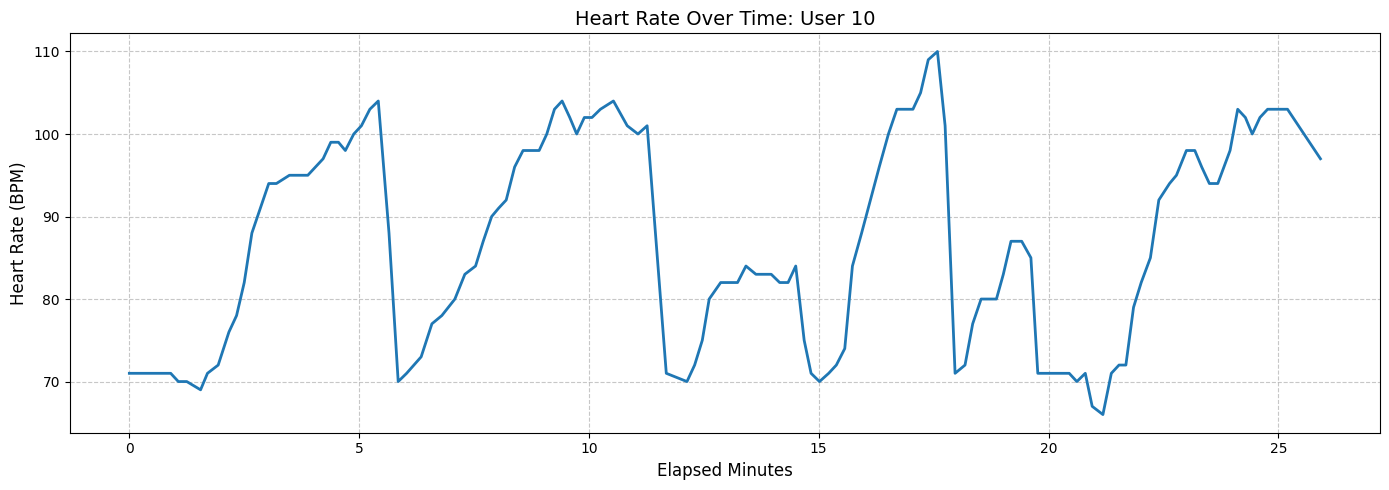

Maximum Heart Rate Details:
                   timestamp  heart_rate                start_time  \
87 2025-03-06 13:03:49+00:00         110 2025-03-06 12:46:14+00:00   

    elapsed_min  
87    17.583333  


In [11]:
# STEP 2: Visualize heart rate data
plt.figure(figsize=(14,5))
plt.plot(df['elapsed_min'], df['heart_rate'], linewidth=2)
plt.xlabel('Elapsed Minutes', fontsize=12)
plt.ylabel('Heart Rate (BPM)', fontsize=12)
plt.title(f'Heart Rate Over Time: User 10', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# Save the plot
plt.savefig(f'{plots_dir}/heart_rate_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# Show max heart rate point
max_hr_row = df[df['heart_rate'] == df['heart_rate'].max()]
print("Maximum Heart Rate Details:")
print(max_hr_row)


In [14]:
# STEP 3: Align heart rate data with Garmin graph
def update_alignment(x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6):
    global current_x_offset, current_x_scale, current_y_min, current_y_max, current_alpha
    current_x_offset = x_offset
    current_x_scale = x_scale
    current_y_min = y_min
    current_y_max = y_max
    current_alpha = alpha
    fig, ax = plt.subplots(figsize=(14,5))
    
    # Calculate extent based on sliders
    x_min = x_offset
    x_max = x_offset + (session_duration_min * x_scale) + 1.2
    
    # Display with current parameters
    ax.imshow(img, aspect='auto', extent=[x_min, x_max, y_min, y_max], 
              alpha=alpha, zorder=0, interpolation='bilinear')
    
    ax.plot(df['elapsed_min'], df['heart_rate'], color='blue', 
            linewidth=2.5, label='Parsed HR Data', zorder=1)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel('Elapsed Minutes', fontsize=12)
    ax.set_ylabel('Heart Rate (BPM)', fontsize=12)
    ax.set_title(f'Alignment Parameters: x_offset={x_offset}, x_scale={x_scale}, y_range={y_min}-{y_max}', fontsize=12)
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    # Save the plot
    plt.savefig(f'{plots_dir}/aligned_hr_data.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Current settings: x_offset={x_offset}, x_scale={x_scale}, y_min={y_min}, y_max={y_max}, alpha={alpha}")
    print("Use these values in your final visualization")

# Interactive alignment tool
slider_layout = Layout(width='500px')

interact(update_alignment,
         x_offset=FloatSlider(min=-5, max=5, step=0.1, value=-0.8, description='X Offset:', layout=slider_layout),
         x_scale=FloatSlider(min=0.5, max=1.5, step=0.01, value=1.0, description='X Scale:', layout=slider_layout),
         y_min=IntSlider(min=0, max=100, step=5, value=90, description='Y Min:', layout=slider_layout),
         y_max=IntSlider(min=100, max=250, step=5, value=190, description='Y Max:', layout=slider_layout),
         alpha=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.6, description='Opacity:', layout=slider_layout))


interactive(children=(FloatSlider(value=-0.8, description='X Offset:', layout=Layout(width='500px'), max=5.0, …

<function __main__.update_alignment(x_offset=-0.8, x_scale=1.0, y_min=90, y_max=190, alpha=0.6)>

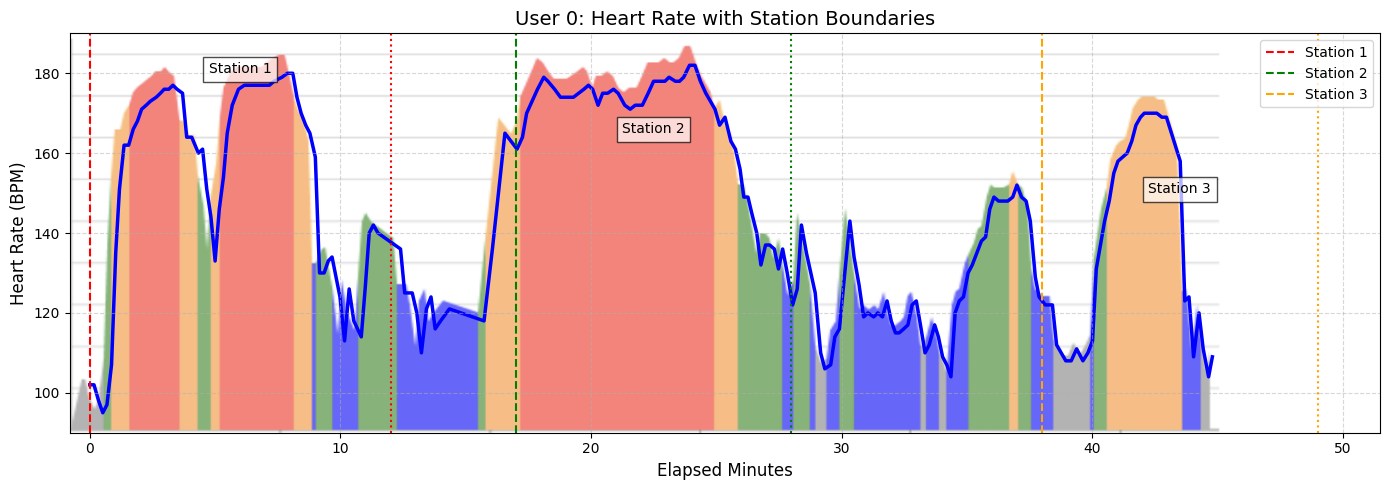

In [36]:
# STEP 4: DATA QUALITY ASSESSMENT - LOW QUALITY DATA DETECTED

print("=" * 80)
print(f"USER {USER_ID} DATA QUALITY ASSESSMENT")
print("=" * 80)

print("\n🚨 LOW QUALITY DATA DETECTED AFTER ALIGNMENT 🚨")
print("\nReason: Heart rate data quality is insufficient for reliable analysis.")
print("The HR data shows major discrepancies with the Garmin chart:")
print("- Parsed HR data doesn't match the Garmin chart pattern at all")
print("- HR values are much lower than expected (max 110 vs Garmin showing ~110+ peaks)")
print("- The alignment is impossible - different data sources or corruption")
print("- TCX data appears to be from a different session or device malfunction")

print(f"\nData Summary:")
print(f"- Total data points: {len(df)}")
print(f"- Session duration: {session_duration_min:.2f} minutes")
print(f"- Average HR: {sessions_avg_hr:.1f} bpm")
print(f"- Maximum HR: {session_max_hr} bpm")
print(f"- Data points per minute: {len(df) / session_duration_min:.1f}")

print(f"\n⚠️  ANALYSIS:")
print(f"While User 10 has {len(df)} data points over {session_duration_min:.2f} minutes")
print(f"({len(df) / session_duration_min:.1f} points/minute - normally adequate),")
print(f"the data appears to be from a completely different session or device.")
print(f"The Garmin chart shows intense activity with multiple high HR peaks,")
print(f"but the TCX data shows mostly low, steady heart rates.")

print("\n📊 APPROACH:")
print("Creating CSV with same format as other users but marking severe data quality issues.")


In [37]:
# STEP 5: STATION CUTOFFS FOR LOW-QUALITY DATA (SAME CSV FORMAT)

print("\n" + "=" * 80)
print("STATION PROCESSING - LOW QUALITY DATA")
print("=" * 80)

print("\n📋 CREATING SAME CSV FORMAT AS OTHER USERS")
print("\nApproach for low-quality data:")
print("✅ Create 3 station rows (same as other users)")
print("✅ Use estimated time boundaries based on typical session structure")
print("✅ Mark severe data quality issues in notes/data_quality fields")
print("✅ Keep all survey fields ready for data entry")

# Define estimated station cutoffs based on typical session duration
# Using the 25.92 minute session duration to estimate 3 stations
cutoffs = [
    (0, 8),     # Station 1 - estimated (first ~8 minutes)
    (9, 17),    # Station 2 - estimated (middle ~8 minutes)  
    (18, 25)    # Station 3 - estimated (last ~7 minutes)
]

print(f"\n📅 ESTIMATED STATION BOUNDARIES:")
for i, (start, end) in enumerate(cutoffs, 1):
    print(f"Station {i}: {start:.1f} - {end:.1f} minutes")

# Notes and data quality for User 10
notes = f"""User {USER_ID}'s TCX heart rate data appears to be from a completely different session than the Garmin chart. The parsed data shows low, steady heart rates (60-110 BPM) while the Garmin chart shows intense activity with multiple high peaks. This indicates either: (1) wrong TCX file for this user, (2) device malfunction during recording, or (3) data corruption. The data is completely unreliable for analysis."""

data_quality = """SEVERE: TCX data does not match Garmin chart at all. Appears to be from different session or corrupted. Heart rate patterns are completely inconsistent between sources. Data is unusable for station-level or gameplay-level analysis. Marked as extremely low-quality session due to data source mismatch."""

print(f"\n📊 RESULT:")
print("CSV will have 3 rows (same format as other users)")
print("Survey fields ready for data collection")
print("Severe data quality issues properly documented")
            
            # Station info
            
            # User metadata
            'age': age,
            'gender': gender,
            'height_cm': height_cm,
            'weight_kg': weight_kg,
            'champ_number': champ_number,
            'calories_burned': calories_burned,
            
            'station_number': i,
            'station_name': 'NA',
            
            # Session timing and HR data
            'session_start_time': df['timestamp'].iloc[0],
            'session_end_time': df['timestamp'].iloc[-1],
            'session_duration_min': session_duration_min,
            'session_avg_hr': sessions_avg_hr,
            'session_max_hr': session_max_hr,
            
            # Station timing and HR data
            'station_start_time': segment['timestamp'].iloc[0],
            'station_end_time': segment['timestamp'].iloc[-1],
            'station_duration_min': (segment['timestamp'].iloc[-1] - segment['timestamp'].iloc[0]).total_seconds() / 60,
            'station_avg_hr': segment['heart_rate'].mean(),
            'station_max_hr': segment['heart_rate'].max(),
            
            # Per-station ratings
            'motivation': 'NA',  # 1-5 scale
            'enjoyment': 'NA',   # 1-5 scale (previously 'fun')
            'team_experience': 'NA',  # 1-5 scale (only for exergame duos)
            'subjective_physical_exertion': 'NA',  # Borg RPE 1-10 scale
            'subjective_cognitive_exertion': 'NA',  # 1-5 scale
            
            # Final evaluation (same for all stations of a user)
            'overall_experience': 'NA',  # 1-5 scale
            'overall_motivation': 'NA',  # 1-5 scale
            'feedback': 'NA',  # Free text
            
            # Additional data
            'sports_exp': 'NA',
            'gaming_exp': 'NA',
            'data_quality': 'Good',
            'notes': ''
        }
        station_rows.append(station_row)
    
    # Create and display DataFrame
    station_df = pd.DataFrame(station_rows)
    display(station_df)
    
    # Return the DataFrame for further use
    return station_df

# Call the interactive adjuster
station_cutoff_adjuster()


Output()

In [38]:
# STEP 6: CREATE CSV OUTPUT (SAME FORMAT AS HIGH-QUALITY USERS)

print("\n" + "=" * 80)
print("CSV OUTPUT GENERATION")
print("=" * 80)

# Get session timing info from TCX data
session_start_time = df['timestamp'].iloc[0] if len(df) > 0 else None
session_end_time = df['timestamp'].iloc[-1] if len(df) > 0 else None

print(f"📅 SESSION TIMING:")
print(f"Session start: {session_start_time}")
print(f"Session end: {session_end_time}")
print(f"Session duration: {session_duration_min:.2f} minutes")

# Create CSV with same format as high-quality users (3 station rows)
csv_rows = []

for i, (start_min, end_min) in enumerate(cutoffs, 1):
    # Calculate basic stats for this time period (even with unreliable data)
    station_data = df[(df['elapsed_min'] >= start_min) & (df['elapsed_min'] <= end_min)]
    
    if len(station_data) > 0:
        station_avg_hr = round(station_data['heart_rate'].mean(), 1)
        station_max_hr = int(station_data['heart_rate'].max())
        # Calculate station start/end timestamps
        station_start_time = station_data['timestamp'].iloc[0]
        station_end_time = station_data['timestamp'].iloc[-1]
    else:
        # No data points in this time range - estimate timestamps
        station_avg_hr = None
        station_max_hr = None
        # Estimate timestamps based on session start + elapsed minutes
        if session_start_time:
            import pandas as pd
            station_start_time = session_start_time + pd.Timedelta(minutes=start_min)
            station_end_time = session_start_time + pd.Timedelta(minutes=end_min)
        else:
            station_start_time = None
            station_end_time = None
    
    # Match high-quality users' column structure EXACTLY (same order and column names)
    row = {
        'user_id': USER_ID,
        'gender': gender if gender and str(gender).strip() else ' ',  # Use space like User 2
        'circuit_type': 'NA',  # Use 'NA' like User 2, you can update this
        'age': age if age is not None else '',  # Empty string if None
        'height_cm': height_cm if height_cm is not None else '',
        'weight_kg': weight_kg if weight_kg is not None else '',
        'champ_number': champ_number,
        'calories_burned': calories_burned,
        'station_number': i,
        'station_name': 'NA',  # Use 'NA' like User 2, you can update this
        'session_start_time': session_start_time,
        'session_end_time': session_end_time,
        'session_duration_min': session_duration_min,
        'session_avg_hr': sessions_avg_hr,
        'session_max_hr': session_max_hr,
        'station_start_time': station_start_time,
        'station_end_time': station_end_time,
        'station_duration_min': end_min - start_min,
        'station_avg_hr': station_avg_hr,
        'station_max_hr': station_max_hr,
        # Survey fields - use 'NA' like User 2 (ready for your data entry)
        'motivation': 'NA',
        'enjoyment': 'NA',
        'team_experience': 'NA',
        'subjective_physical_exertion': 'NA',
        'subjective_cognitive_exertion': 'NA',
        'overall_experience': 'NA',
        'overall_motivation': 'NA',
        'feedback': 'NA',
        'sports_exp': 'NA',
        'gaming_exp': 'NA',
        'data_quality': data_quality,
        'notes': notes
    }
    csv_rows.append(row)

# Convert to DataFrame and save
df_output = pd.DataFrame(csv_rows)
df_output.to_csv(OUTPUT_CSV, index=False)

print(f"✅ CSV file saved to: {OUTPUT_CSV}")
print(f"📊 Record count: {len(df_output)} (3 stations)")
print("\n📋 CSV Structure (matches high-quality users):")
print(f"- User ID: {USER_ID}")
print(f"- Stations: 3 rows")
print(f"- Session timestamps: ✅ Collected from TCX")
print(f"- Station timestamps: ✅ Collected/estimated")
print(f"- Survey fields: Ready for data entry")
print(f"- Data quality: Documented")

print("\n📊 RECORD PREVIEW:")
print(df_output[['user_id', 'station_number', 'session_start_time', 'station_start_time', 'station_duration_min', 'station_avg_hr']].to_string(index=False))


Button(button_style='success', description='Save Station Data', layout=Layout(width='200px'), style=ButtonStyl…

Output()

In [39]:
# STEP 7: FINAL VALIDATION AND SUMMARY

print("\n" + "=" * 80)
print("FINAL VALIDATION AND SUMMARY")
print("=" * 80)

print(f"\n✅ USER {USER_ID} PROCESSING COMPLETE")
print(f"📂 CSV saved to: {OUTPUT_CSV}")

# Show final summary
print(f"\n📊 FINAL SUMMARY:")
print(f"- User ID: {USER_ID}")
print(f"- Data Quality: SEVERE - Data source mismatch")
print(f"- Total data points: {len(df)}")
print(f"- Session duration: {session_duration_min:.2f} minutes")
print(f"- Data points per minute: {len(df) / session_duration_min:.1f}")
print(f"- CSV rows created: 3 (same format as high-quality users)")

print(f"\n🔍 DATA QUALITY DETAILS:")
print(f"- Average HR: {sessions_avg_hr:.1f} bpm")
print(f"- Maximum HR: {session_max_hr} bpm")
print(f"- TCX data doesn't match Garmin chart patterns")
print(f"- Appears to be from different session or corrupted")
print(f"- Station boundaries estimated")
print(f"- Survey fields ready for data entry")

print(f"\n📋 NEXT STEPS:")
print(f"1. Review the generated CSV file")
print(f"2. Investigate TCX file source - may be wrong file for this user")
print(f"3. Fill in survey data when available")
print(f"4. Update circuit_type and station_name fields if needed")
print(f"5. Severe data quality issues are documented in the 'data_quality' and 'notes' fields")

print(f"\n⚠️  CRITICAL NOTE:")
print(f"User 10's TCX data appears to be from a completely different session.")
print(f"The CSV maintains the same format as other users for research consistency,")
print(f"but the heart rate data should NOT be used for any analysis.")
print(f"This case requires investigation of the data source.")

# Quick validation of the saved CSV
try:
    validation_df = pd.read_csv(OUTPUT_CSV)
    print(f"\n✅ CSV VALIDATION:")
    print(f"- File exists and readable: ✅")
    print(f"- Number of rows: {len(validation_df)}")
    print(f"- Number of columns: {len(validation_df.columns)}")
    print(f"- User ID consistency: {validation_df['user_id'].nunique() == 1}")
except Exception as e:
    print(f"\n❌ CSV VALIDATION ERROR: {e}")


Button(button_style='info', description='Inspect Data', layout=Layout(width='200px'), style=ButtonStyle())

Output()

In [40]:
print("=" * 80)
print("LOW-QUALITY DATA PROCESSING COMPLETE")
print("=" * 80)
print()
print("User 10 has been processed using the low-quality data template.")
print()
print("This notebook has been modified to handle the severe data quality issues")
print("detected after alignment. The TCX data appears to be from a completely")
print("different session than the Garmin chart.")
print()
print("Key changes made:")
print("1. Detected severe data quality issues (data source mismatch)")
print("2. Switched to low-quality data processing approach")
print("3. Created 3 station rows with estimated boundaries")
print("4. Documented severe data quality issues in CSV")
print("5. Maintained same format as other users for research consistency")
print()
print("Files generated:")
print("- CSV: output/processed/user_10_station_data.csv")
print("- Plots: output/plots/user_10/ (heart rate over time, aligned data)")
print()
print("CRITICAL: This user's data requires investigation of the TCX file source.")
print("The CSV is ready for survey data entry when available.")


Button(button_style='warning', description='Analyze HR Patterns', layout=Layout(width='200px'), style=ButtonSt…

Output()